# Detecting Tsunami-related Total Electron Content Anomalies in the Ionosphere with Convolutional Neural Networks

The above title may be changed at a later date. 

## Imports

In [1]:
import datetime
from datetime import timedelta
import fastai
from fastai.vision.all import *
import fastprogress
from hyperdash import monitor_cell, Experiment
import matplotlib.pyplot as plt
import natsort
import numpy as np
import os 
import seaborn as sns
from sklearn.preprocessing import minmax_scale
from tqdm.notebook import tqdm

## Establish an Experiment

In [2]:
# Create an experiment with a model name, then autostart
exp = Experiment("DEV - Tsunami-related sTEC d/dt Anomaly Detection")

{ device_name: GeForce RTX 2080 Ti }
{ data_path_train: /u/scratch/s/stecproj/image_data/image_based_balanced/hawaii/train }
{ batch_size: 256 }
Could not do one pass in your dataloader, there is something wrong in it
{ architecture: <function resnet34 at 0x2ae779f25e50> }
{ learning_rate: 1e-05 }
{ parallel_gpus: False }
{ coverage_threshold: 0.9 }
{ epochs_max: 50 }


## Establishing CUDA device

In [3]:
# checking device number
assert torch.cuda.is_available()
index_device = torch.cuda.current_device()
device_name = exp.param("device_name", torch.cuda.get_device_name(index_device))

## Read Data

In [4]:
# set the data path and model save path
# data_path_train = "/home/vconstan/projects/sTEC-d-dt-Anomaly-Detection/data/image_based_balanced/hawaii/train"

data_path_train = "/u/scratch/s/stecproj/image_data/image_based_balanced/hawaii/train"
data_path_train = exp.param("data_path_train", data_path_train)

In [5]:
# set the batch size 
batch_size = 256
batch_size = exp.param("batch_size", batch_size)

In [6]:
# load in the data 
dls = ImageDataLoaders.from_folder(
    data_path_train, 
    item_tfms=Resize(224),
    valid_pct=0.2,
    bs=batch_size, 
    ds_tfms=aug_transforms(do_flip=True, flip_vert=True)
)

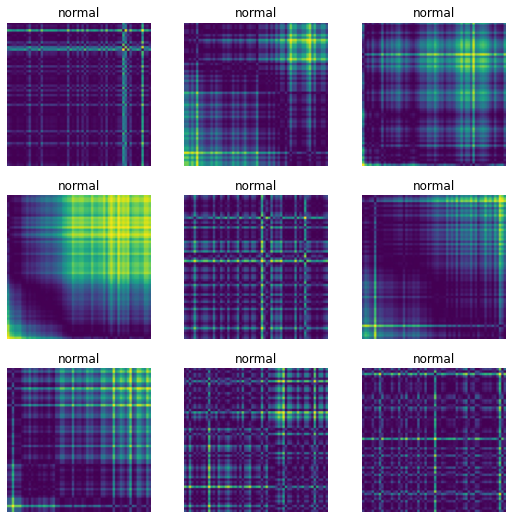

In [7]:
# show 9 sample images with correspond to our two labels in the dataset - normal and anomalous 
dls.show_batch()

In [8]:
# dls.dataset

In [9]:
# dls.dataset = dls.dataset.new(shuffle=False, sampler=ImbalancedDatasetSampler)

## Model Data

In [10]:
# define the learner 
architecture = resnet34

learn = cnn_learner(
    dls, # data
    architecture, # architecture 
    metrics=[error_rate, accuracy], # metrics
    pretrained=False, # whether or not to use transfer learning
    normalize=True, # this function adds a Normalization transform to the dls
#     callback_fns=[]
)

architecture = exp.param("architecture", architecture)

In [11]:
# learn.show_training_loop()

In [12]:
# for now, manually set the learning rate (automatic LR finders left for future work)
lr = 0.00001 # 0.00001 best result so far but not a given 
lr = exp.param("learning_rate", lr)

In [13]:
# parallel GPUs! Seems to work with squeezenet but not with resnet models (have not tried densenet, VGG or others)
parallel_gpus = False
# if torch.cuda.device_count() > 1:
#     parallel_gpus = True
#     learn.model = nn.DataParallel(learn.model)
parallel_gpus = exp.param("parallel_gpus", parallel_gpus)

## Metric functions

In [14]:
# set a threshold for calculating coverage
coverage_threshold = exp.param("coverage_threshold", 0.9)

In [15]:
def confusion_matrix_scores(cm: np.ndarray):
    """
    Returns a tuple of classification metrics according to
    the anomalous class as True Positive
    """
    accuracy = np.trace(cm)/np.sum(cm)
    total_anon = np.sum(cm[0]) if np.sum(cm[0]) > 0 else 1
    pred_anon = np.sum(cm[:, 0]) if np.sum(cm[:, 0]) > 0 else 1
    precision = cm[0, 0] / total_anon
    recall = cm[0, 0] / pred_anon
    denom = (precision + recall) if (precision + recall) > 0 else 1
    F1 = 2 * precision * recall / denom
    return accuracy, precision, recall, F1

def calculating_coverage(predictions: torch.Tensor, targets: torch.Tensor, threshold: float):
    """
    Given a N-sized validation set,
    predictions is an N x 2 tensor since this is a binary classification problem
    targes is an N x 1 tensor where each targets[i] is the correct class
    
    returns 2 tuple of all coverages of each class
    """
    anomalous = np.where(targets == 0)
    normal = np.where(targets == 1)
    normal_predictions = predictions[normal, 1]
    anomalous_predictions = predictions[anomalous, 0]
    anom_coverage = np.average(anomalous_predictions > threshold)
    normal_coverage = np.average(normal_predictions > threshold)
    return anom_coverage, normal_coverage
    

In [16]:
# max number of epochs
epochs_max = exp.param("epochs_max", 50)

In [ ]:
# Hyperdash API key: HaWsBsqUzqosfHQPw7XMSwl9l1gnGiUr05uydAzqxfo=

# set the parameters 
# TODO: size training
# TODO: size validation 
# TODO: size holdout 
# TODO: holdout channels (ground station, satellite combinations)
# TODO: pretrained 
# TODO: normalize 
# TODO: callbacks 

# train the model 
learn.fit(
    epochs_max, 
    lr=lr,
    cbs=[
        ShowGraphCallback(),
        CSVLogger(),
#         ParamScheduler(sched),
        ReduceLROnPlateau(
            monitor='valid_loss', 
            min_delta=0.001, 
            patience=5
        ),
        EarlyStoppingCallback(
            monitor="valid_loss",
            patience=10,
            min_delta=0.00001
        ),
        SaveModelCallback()
    ]
) 

# TODO: total training time 
# TODO: train loss, valid loss, error rate 


epoch,train_loss,valid_loss,error_rate,accuracy,time


In [ ]:
# plot the loss curve from model training
learn.recorder.plot_loss()

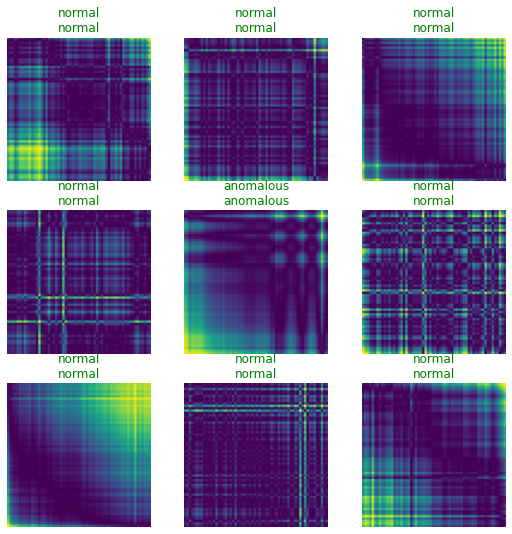

In [37]:
learn.show_results(max_n=9)

In [38]:
interp = ClassificationInterpretation.from_learner(learn)

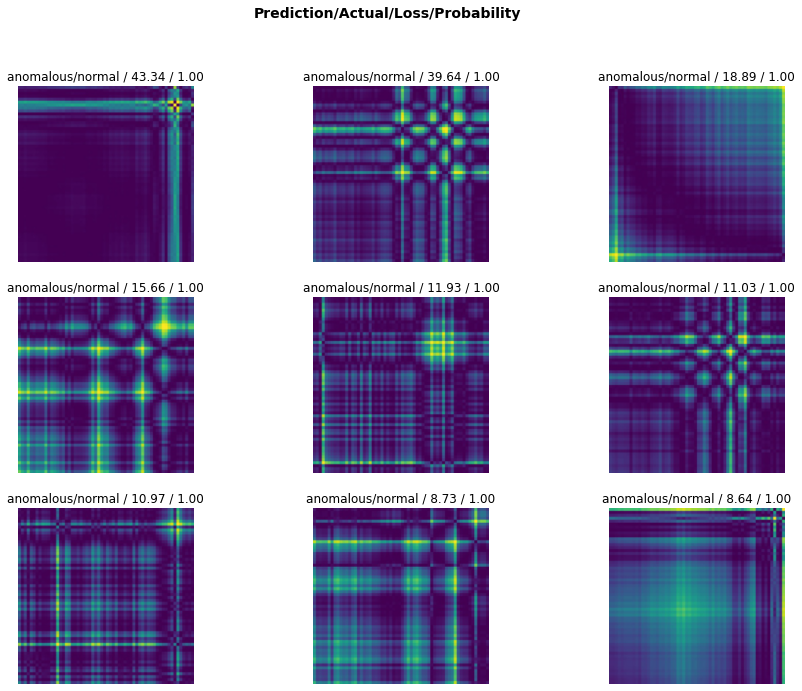

In [39]:
interp.plot_top_losses(9, figsize=(15,11))

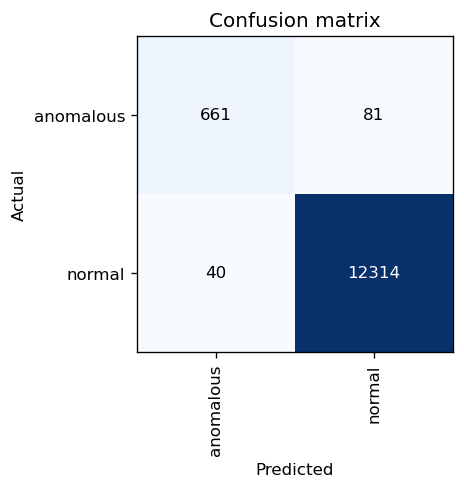

In [40]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=120)

In [41]:
# interpret results from test set
cm = interp.confusion_matrix()

results = confusion_matrix_scores(cm)
accuracy = exp.metric("accuracy", results[0])
precision = exp.metric("precision", results[1])
recall = exp.metric("recall", results[2])
F1_score = exp.metric("F1 Score", results[3])


# coverage calculation
predictions, targets = learn.get_preds() #by default uses validation set
anom_cov, normal_cov = calculating_coverage(predictions, targets, coverage_threshold)
anomaly_cov = exp.metric("anomaly coverage", anom_cov)
normal_cov = exp.metric("normal coverage", normal_cov)


## Export and Save the Model

In [3]:
learn.export("/u/scratch/s/stecproj/models/model.pkl") # TODO: clean up export path and where model saves history, etc. 
# "/u/scratch/s/stecproj/models"

NameError: name 'learn' is not defined

## TODO: Load in Saved Model

In [2]:
learn = load_learner("/u/scratch/s/stecproj/models/model.pkl")

### Real-World Experiment 

In [3]:
# set path for the validation set of data 
data_path_validation = "/u/scratch/s/stecproj/image_data/image_based_balanced/hawaii/validation"
# data_path_validation = exp.param("data_path_validation", data_path_validation)

##### General functions

In [43]:
def group_consecutives(vals, step=1):
    """Return list of consecutive lists of numbers from vals (number list).
    https://stackoverflow.com/questions/7352684/how-to-find-the-groups-of-consecutive-elements-in-a-numpy-array
    """
    run = []
    result = [run]
    expect = None
    for v in vals:
        if (v == expect) or (expect is None):
            run.append(v)
        else:
            run = [v]
            result.append(run)
        expect = v + step
    return result



In [44]:
def read_data(ground_station_name: str, sat_name: str) -> pd.DataFrame:
    """
    simple read data function that converts the txt data files into pandas dataframes
    :input ground_station_name:
    :input sat_name:
    :output: pd.DataFrame
    """
    pass_id = ground_station_name + "__" + sat_name
    try:
        sat = "../data/hawaii/2012/302/" + ground_station_name + "3020.12o_" + sat_name + ".txt"

        f = open(sat, 'r')
        line1 = f.readline()

    except:
        print("Error reading float data!")

    line1 = line1.replace('#', '').replace("dsTEC/dt [TECU/s]", "dsTEC/dt").replace("elev", "ele")
    rename_cols = line1.split()
    rename_cols.remove("sod")
    new_cols = list()

    # rename the columns
    for rn_col in rename_cols:
        new_col = pass_id + "_" + rn_col
        if rn_col == "dsTEC/dt":
            new_col = pass_id
        new_cols.append(new_col)
    new_cols = ["sod"] + new_cols


    df = pd.read_table(
        sat,
        index_col='sod',
        sep="\t\t| ",
        names=new_cols,
        engine="python",
        skiprows=1
    )

    new_cols.remove('sod')

    sod = df.index
    timestamps = list()
    date = datetime(2012, 1, 1) + timedelta(302 - 1)

    for s in sod:

        # hours, minutes, seconds
        hours = int(s // 3600)
        minutes = int((s % 3600) // 60)
        seconds = int((s % 60))

        # create a datetime object and append to the list
        date_time = datetime(date.year, date.month, date.day, hours, minutes, seconds)
        timestamps.append(date_time)


    df["timestamp"] = timestamps
    new_cols.append("timestamp")

    # now that we have read in the data, do some formatting 
    df = df[new_cols].reset_index()
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df.index = df["timestamp"]
    df = df.resample("1Min").mean()
    
    return df

In [45]:
def period_class(length_images, windows, classification, classification_confidence):
    
    window_end = windows[-1][1] + 1
    
    period_classification_df = pd.DataFrame(
        index=list(range(0, length_images)),
        columns=list(range(0, window_end - 1))
    ).astype(float)

    # note that this matrix can be used to classify anomalies with different weighting schemes
    # this is left for future work. We take the naive approach and say that any time index 
    # identified as anomaly is one 
    # and fill 
    index = 0
    for c, cc, w in zip(classification, classification_confidence, windows):
        if c == "normal":
            val = 0
        else:
            val = 1
        period_classification_df.iloc[index, w[0]:w[1]] = val
        index += 1
        
    return period_classification_df

In [46]:

# TODO: add typing for learner
def real_world_simulation(data_path: str, learner: fastai.learner.Learner, verbose: bool = False, 
                         save_path: str = None) -> None: 
    
    # define the annotations we use later for visualization and metrics reporting 
    sod_annotations = {
        "G04": 31400,
        "G07": 31160,
        "G08": 31900,
        "G10": 29900,
        "G20": 31150
    }
    
    # TODO: fix unintended printing from fastai
    with learner.no_bar():
                
        # disable logging 
        learner.no_logging()

        # first get all of the directories at the specified path 
        directories = [
            d for d in os.listdir(data_path) if os.path.isdir(data_path + '/' + d)
        ]

        tp_tot = 0
        fn_tot = 0
        fp_tot = 0

        # now run predictions on each example in the data set
        for d in tqdm(directories): 

            try:

                sat_name = d.split("__")[1]
                ground_station_name = d.split("__")[0]
                pass_id = ground_station_name + "__" + sat_name

                # get all of the image files from the day of the earthquake 
                # TODO: use all of the days not just the day of the earthquake for validation (depends on timing)

                # get all of the image paths in that directory for the day of the earthquake
                image_files = [f for f in natsort.natsorted(os.listdir(data_path + "/" + d + "/unlabeled")) if ".jpg" in f and "302" in f.split("_")[0]]
                
                
                # make predictions for all of the images from that day 
                # these were converted previously. In real world would need real-time conversion from float to image and 
                # then to classification 
                # for each image (window), predict and store the classification 
                classification = list()
                classification_confidence = list()
                windows = list()
                window_start = 0
                window_end = 60
                for img in image_files: 

                    try:

                        # load in the image and predict the classification 
                        prediction = learner.predict(data_path + "/" + d + "/unlabeled/" + img)
                        

                        # store the classification and the window range 
                        classification.append(prediction[0])
                        classification_confidence.append(np.max(prediction[2].cpu().detach().numpy()))

                        windows.append([window_start, window_end])
                        window_start += 1
                        window_end += 1    
                    except Exception as e:
                        
                        print("Error encountered when predicting!")
                        if e is KeyboardInterrupt:
                            break
                            

                classification_bool = [0 if x == "normal" else 1 for x in classification]


                # store the classification result in a time-indexed array that is T minutes long by W windows tall 
                # the number of minutes T is the number of windows plus the window size, or window_end
                period_classification_df = period_class(len(image_files), windows, classification, classification_confidence)
                    
                # now we need to load in the original data (float data) that contains the second of day 
                # and other data needed for visualization and metrics reporting 
                df = read_data(ground_station_name, sat_name)
            
                # identify continuous periods as we do when we generate the images and prep the data 
                events = np.split(df, np.where(np.isnan(df))[0])
                events = [ev[~np.isnan(ev)] for ev in events if not isinstance(ev, np.ndarray)]
                events = [ev.dropna() for ev in events if not ev.empty and ev.shape[0] > 100]

                # generate the normalized events in case we need them 
                normalized_events = list()
                for ev in events: 

                    # for each column in the data, rescale -1 to 1 
                    col_data = list()
                    for col in ev.columns.values:

                        normalized_data = minmax_scale(
                                    ev[col].dropna(), 
                                    feature_range=(-1, 1)
                                )
                        col_data.append(normalized_data)

                    df_period = pd.DataFrame(np.array(col_data).T, columns=list(ev.columns.values) )
                    df_period["timestamp"] = ev[col].index
                    df_period.index = df_period["timestamp"]
                    df_period = df_period.drop(columns=["timestamp"])

                    # convert to seconds of the day for later annotation 
                    df_period["sod"] = (df_period.index.hour*60+df_period.index.minute)*60 + df_period.index.second

                    normalized_events.append(df_period)


                #  # TODO: okay so now let's generate some metrics
                # like the code that generates the "events", we will determine the predicted 
                # sequence of anomalies and record whether or not they are true positives 

                # For simplicity, we do not make scoring adjustments based on
                # how early an anomaly was detected or the distance between false
                # positives and labeled regions
                ground_truth = [
                    sod_annotations[sat_name],
                    sod_annotations[sat_name] + (30 * 60) # 30 minutes 
                ]

                # for now assume events is length 1 # TODO fix later
                
                event = events[0].reset_index()
                
                ground_truth_sequence = event[(event["sod"] >= ground_truth[0]) & (event["sod"] <= ground_truth[1])].index.values
                
        
                adjusted_ground_truth_sequence = [x - 59 for x in ground_truth_sequence]
        
                # NOTE the adjustment below for the window size 

                
                
                # get the indices of the anomalous values 
                anom_idx = np.where(np.array(classification_bool) == 1)
                
                anom_sequences = group_consecutives(list(anom_idx[0]))

                # A true positive is recorded if any portion of a predicted sequence of anomalies falls within any
                # true labeled sequence. Only one true positive is recorded
                # even if portions of multiple predicted sequences fall within
                # a labeled sequence.

                # If no predicted sequences overlap with a positively labeled
                # sequence, a false negative is recorded for the labeled sequence

                # For all predicted sequences that do not overlap a labeled
                # anomalous region, a false positive is recorded

                tp = 0
                fn = 0
                fp = 0

                # TODO: Hamlin please double check me on this 
                # NOTE: current code assumes one anomalous sequence 

                # check for false positives and true positives 
                for anom_seq in anom_sequences: 
                    
                    intersection = list(set(adjusted_ground_truth_sequence) & set(anom_seq)) 
                    
                    if len(intersection) > 0:
                        tp = 1 
                        fn = 0
                    else:
                        fp += 1
                        
                # check for false negatives 
                fn = 1
                for anom_seq in anom_sequences: 
                    intersection = list(set(adjusted_ground_truth_sequence) & set(anom_seq)) 
                    if len(intersection) > 0:
                        
                        fn = 0
                        break

                tp_tot += tp
                fn_tot += fn
                fp_tot += fp

                # make pretty plots! 
                if verbose: 

                    # combined "detection evaluation" plot
                    fig, axs = plt.subplots(3, sharex=False, sharey=False, figsize=(12, 4))
                    fig.tight_layout()
                    fig.suptitle('Day of Earthquake Predictions by Second of Day (SoD) for ' + pass_id + "\n")

                    gs = plt.GridSpec(3, 1, height_ratios=[3, 1, 1]) 

                    axs[0] = plt.subplot(gs[0])
                    # NOTE the adjustment below for the window size 
                    sns.lineplot(data=events[0].iloc[59:, :], x="sod", y=pass_id, ax=axs[0])
                    axs[0].set(yticklabels=[]) 
                    axs[0].axvline(x=sod_annotations[sat_name], linestyle="dotted") # start 
                    axs[0].axvline(x=sod_annotations[sat_name] + (30 * 60), linestyle="dotted") # approx end - 30 minutes later 
                    #TODo: do we need to revisit data generation / labeling? 
                    axs[0].margins(x=0)
                    axs[0].set_xlabel("")

                    axs[1] = plt.subplot(gs[1])
                    sns.heatmap(np.array([classification_bool]), cbar=False, cmap="plasma", xticklabels=False, yticklabels=False, ax=axs[1])
                    axs[1].set_xlabel("Prediction (yellow is anomaly)") 

                    axs[2] = plt.subplot(gs[2])
                    sns.heatmap(np.array([classification_confidence]), cbar=False, cmap="plasma_r", xticklabels=False, yticklabels=False, ax=axs[2]) # .replace(0, np.nan)
                    axs[2].set_xlabel("Prediction Confidence (yellow is worse)") 


                    plt.subplots_adjust(left=0.125,
                                        bottom=0.1, 
                                        right=0.9, 
                                        top=0.9, 
                                        wspace=0.2, 
                                        hspace=0.5)

                    plt.show()
                    
                    
                    # now a geographic plot! 
                    
                if save_path is not None:
                    print('Saving File of: ', pass_id)
                    try:
                        save_df = event.iloc[59:].copy()
                        save_df['anomaly'] = classification_bool 
                        save_df['confidence'] = classification_confidence
                        save_df.to_csv(save_path + pass_id + '_results.csv')
                    except FileNotFoundError:
                        print('Save Path not valid')
                        
                

            except Exception as e: 
                
                print("ERROR: ", d)
                if e is KeyboardInterrupt:
                    break
                print(e)
                continue
                
        try:
            precision = tp_tot / (tp_tot + fp_tot)
        except ZeroDivisionError:
            precision = 0.
            
        try:
            recall = tp_tot / (tp_tot + fn_tot)
        except ZeroDivisionError:
            recall = 0.
        try:
            f1_score = 2 * ((precision * recall) / (precision + recall))
        except ZeroDivisionError:
            f1_score = 0.
            
        precision = exp.metric("validation_precision", precision)
        recall = exp.metric("validation_recall", recall)
        f1_score = exp.metric("validation_f1_score", f1_score)
        



  0%|          | 0/33 [00:00<?, ?it/s]

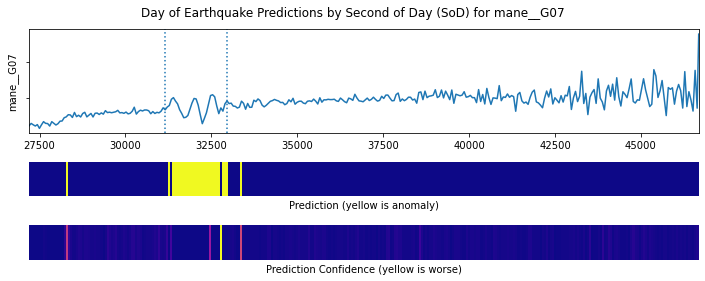

Saving File of:  mane__G07


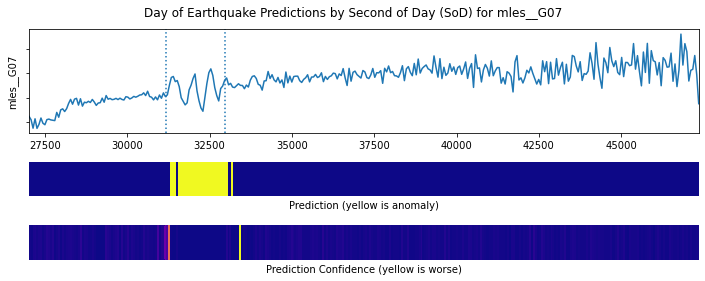

Saving File of:  mles__G07


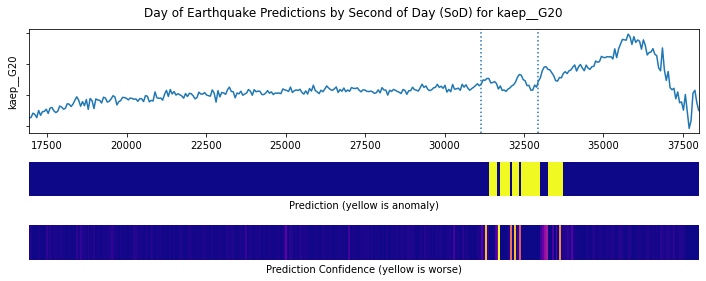

Saving File of:  kaep__G20


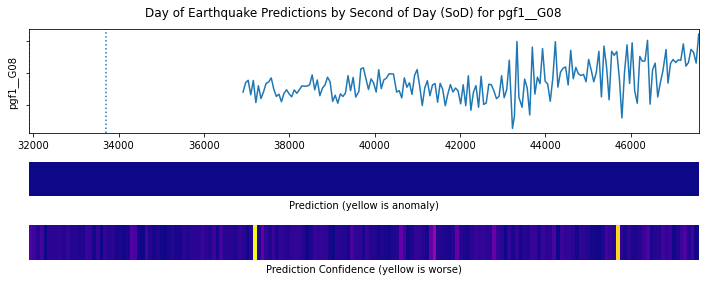

Saving File of:  pgf1__G08


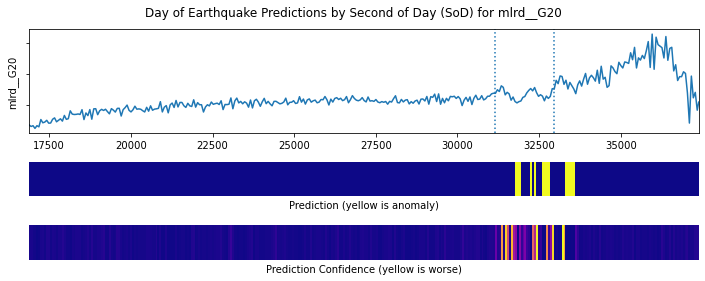

Saving File of:  mlrd__G20


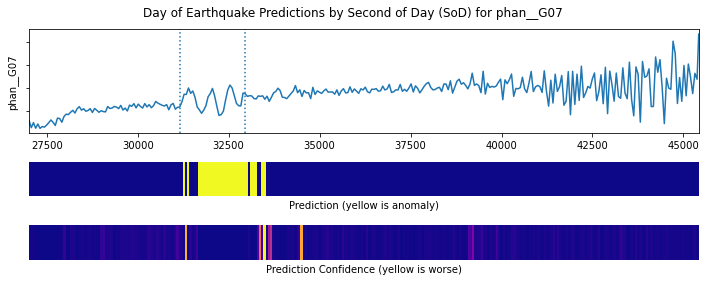

Saving File of:  phan__G07


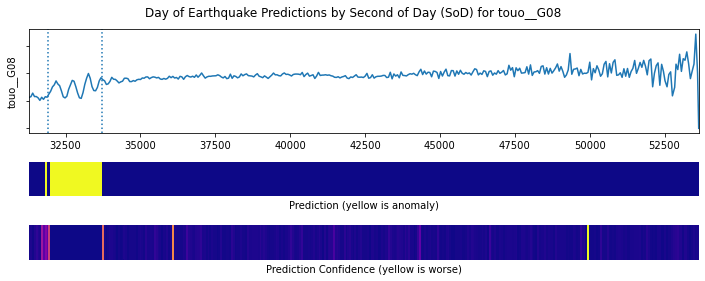

Saving File of:  touo__G08


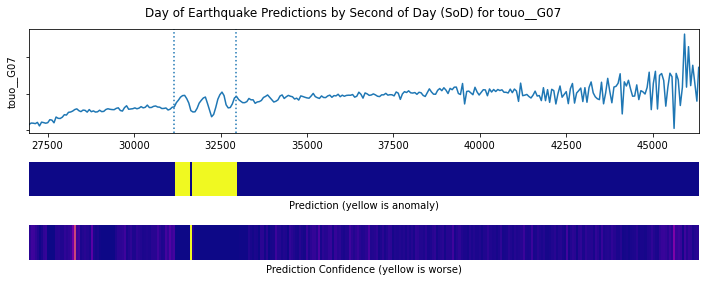

Saving File of:  touo__G07


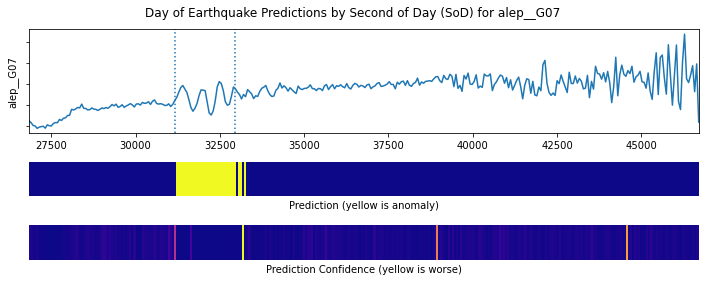

Saving File of:  alep__G07


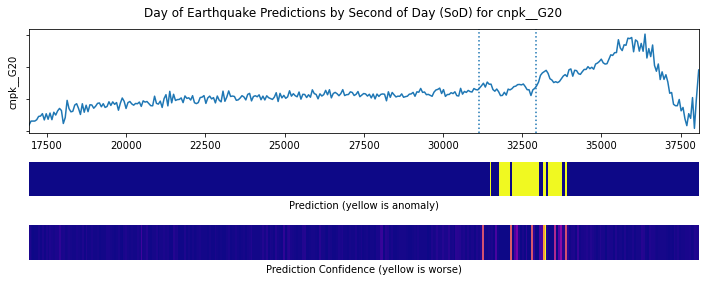

Saving File of:  cnpk__G20


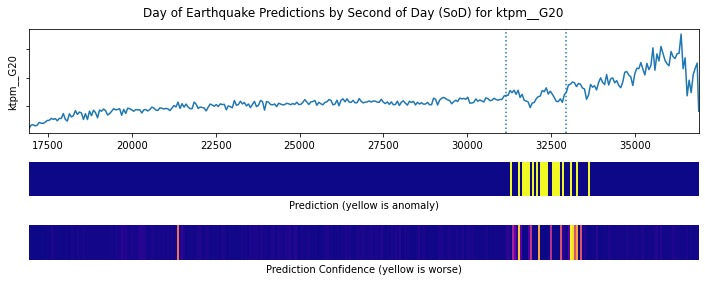

Saving File of:  ktpm__G20


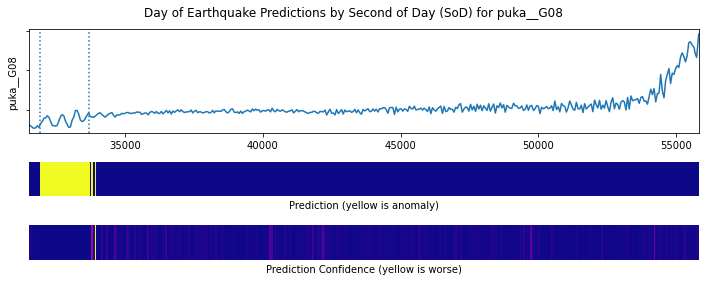

Saving File of:  puka__G08
ERROR:  maui__G20
list index out of range


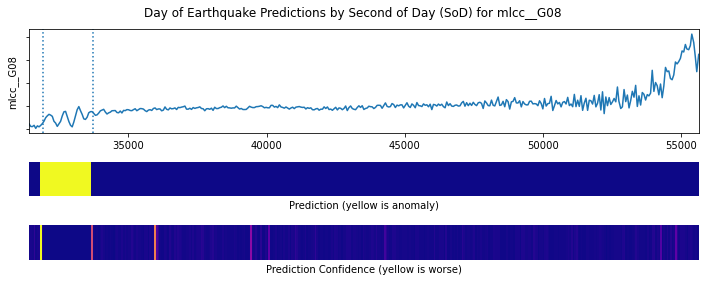

Saving File of:  mlcc__G08


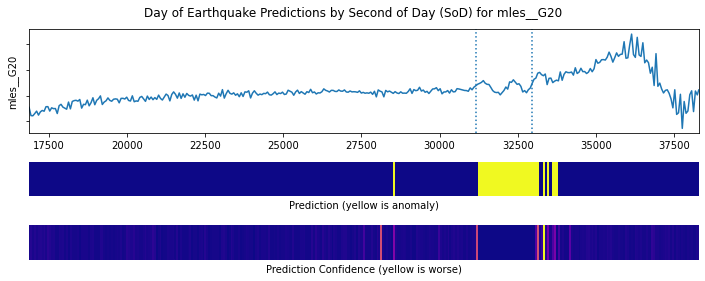

Saving File of:  mles__G20


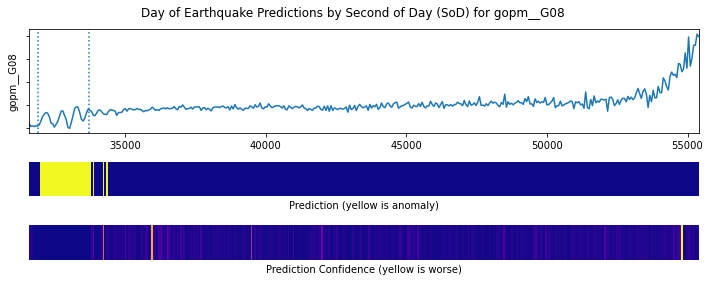

Saving File of:  gopm__G08


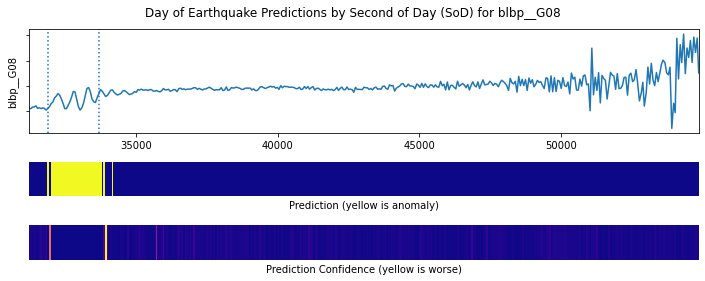

Saving File of:  blbp__G08


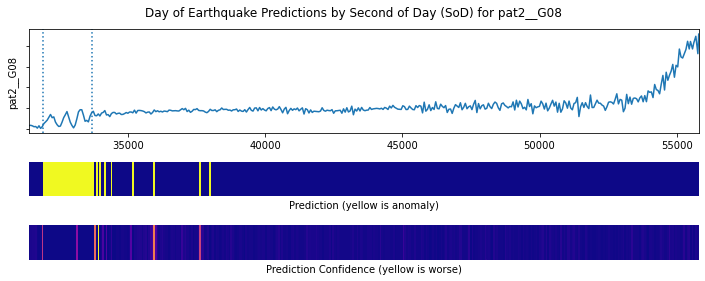

Saving File of:  pat2__G08


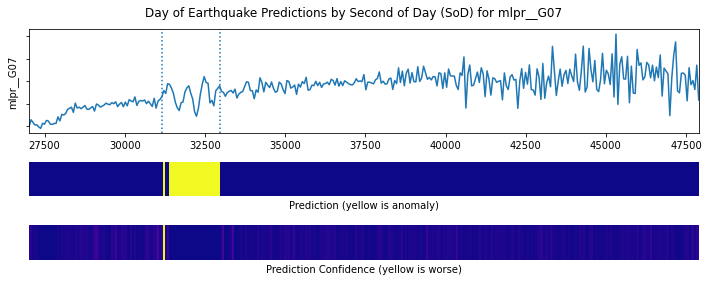

Saving File of:  mlpr__G07


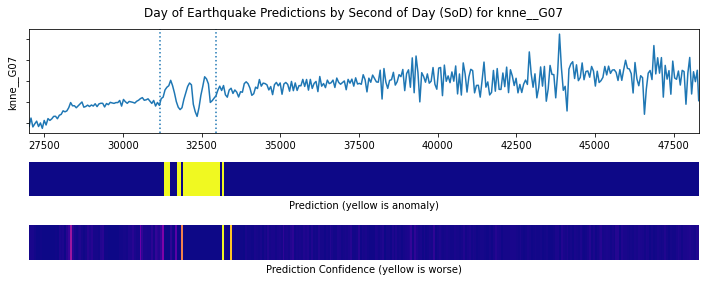

Saving File of:  knne__G07


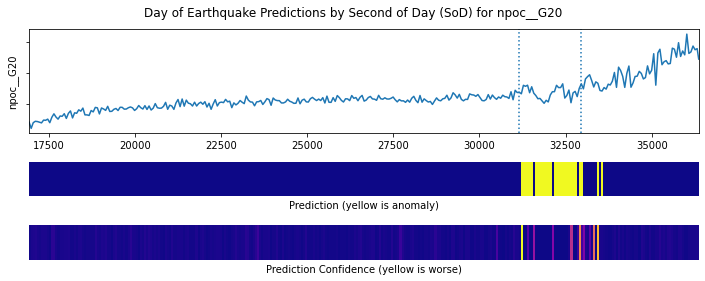

Saving File of:  npoc__G20


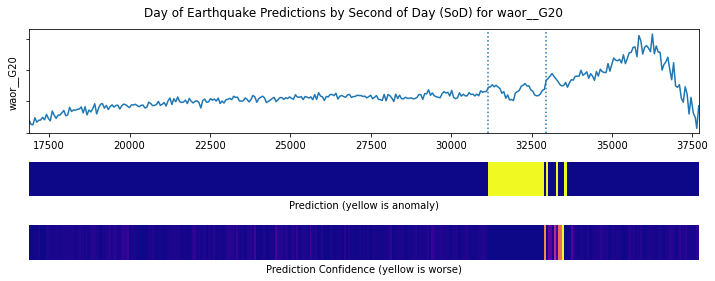

Saving File of:  waor__G20


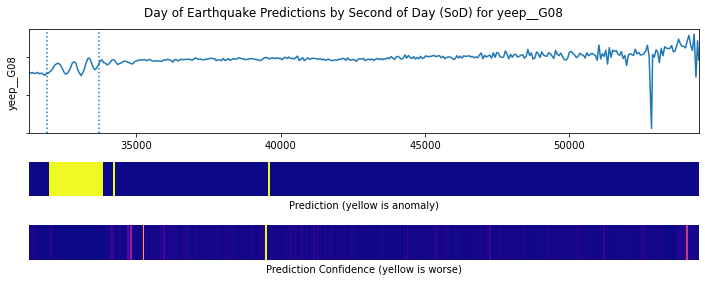

Saving File of:  yeep__G08
ERROR:  pgf5__G20
list index out of range


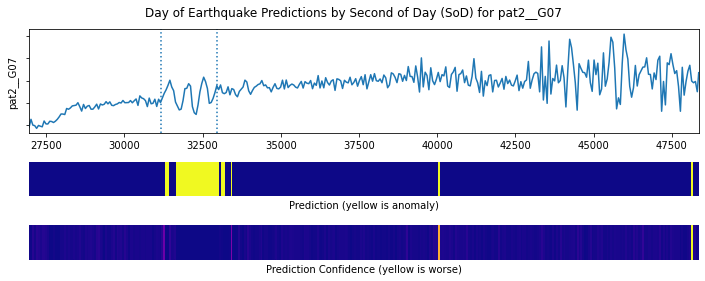

Saving File of:  pat2__G07


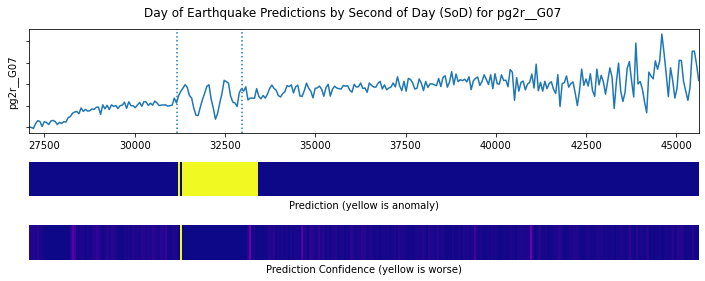

Saving File of:  pg2r__G07


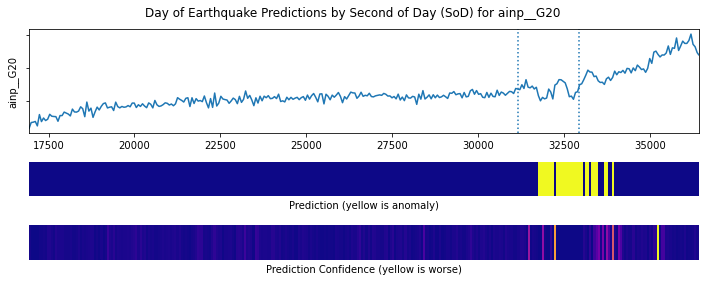

Saving File of:  ainp__G20


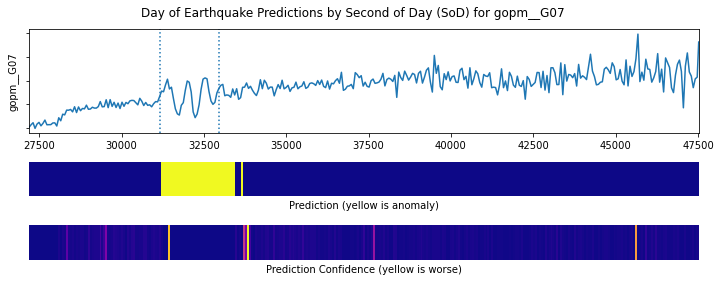

Saving File of:  gopm__G07


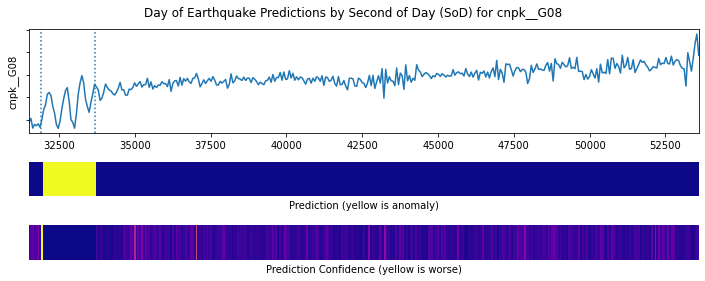

Saving File of:  cnpk__G08


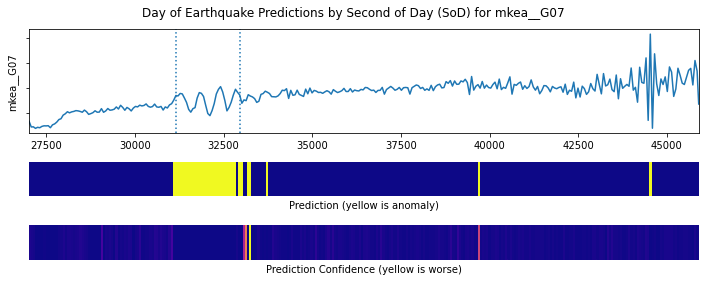

Saving File of:  mkea__G07


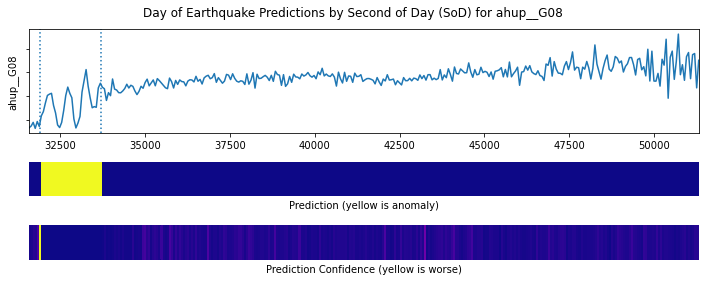

Saving File of:  ahup__G08


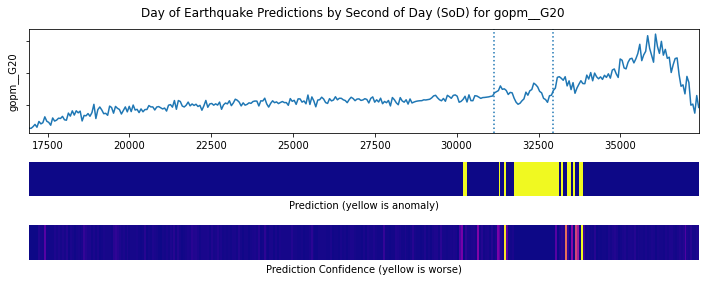

Saving File of:  gopm__G20


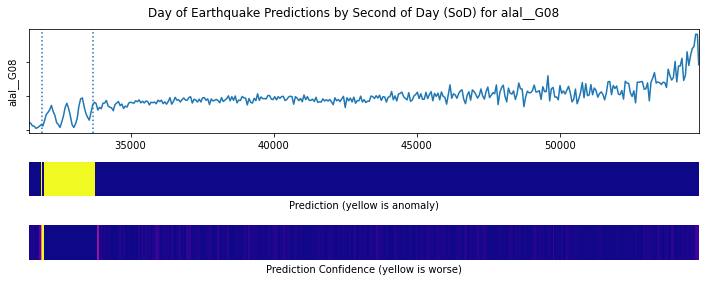

Saving File of:  alal__G08


NameError: name 'exp' is not defined

In [48]:
real_world_simulation(
    data_path=data_path_validation,
    learner=learn,
    verbose=True,
    save_path='~/test_results/'
)

## End the Experiment

In [ ]:
# end the experiment 
exp.end()

### Below is older code that exists above and ought to be refactored and made nice 

In [30]:
type(learn)

fastai.learner.Learner

In [4]:
ground_station_name = 'gopm'
sat_name = 'G07'

In [5]:
# work in progress. For now, building out base functionality with a single set of data in the validation set 
test_path = data_path_validation + "/gopm__G07/unlabeled/"

In [6]:
# get all of the image paths in that directory for the day of the earthquake
image_files = [f for f in natsort.natsorted(os.listdir(test_path)) if ".jpg" in f and "302" in f.split("_")[0]]
image_files[0:10]

['302_0_60_GAF.jpg',
 '302_1_61_GAF.jpg',
 '302_2_62_GAF.jpg',
 '302_3_63_GAF.jpg',
 '302_4_64_GAF.jpg',
 '302_5_65_GAF.jpg',
 '302_6_66_GAF.jpg',
 '302_7_67_GAF.jpg',
 '302_8_68_GAF.jpg',
 '302_9_69_GAF.jpg']

In [7]:
# for each image (window), predict and store the classification 

classification = list()
classification_confidence = list()
windows = list()


window_start = 0
window_end = 60
with learn.no_bar():
    for img in tqdm(image_files): 

        # load in the image and predict the classification 
        prediction = learn.predict(test_path + img)

        # store the classification and the window range 
        classification.append(prediction[0])
        classification_confidence.append(np.max(prediction[2].cpu().detach().numpy()))

        windows.append([window_start, window_end])
        window_start += 1
        window_end += 1    
    

  0%|          | 0/340 [00:00<?, ?it/s]

In [8]:
classification_bool = [0 if x == "normal" else 1 for x in classification]

In [9]:
windows[-1]

[339, 399]

In [10]:
window_end

400

In [11]:
# store the classification result in a time-indexed array that is T minutes long by W windows tall 
# the number of minutes T is the number of windows plus the window size, or window_end
period_classification_df = pd.DataFrame(
    index=list(range(0, len(image_files))),
    columns=list(range(0, window_end - 1))
).astype(float)

# and fill 
index = 0
for c, cc, w in zip(classification, classification_confidence, windows):
    
    if c == "normal":
        val = 0
    else:
        val = 1
    
    period_classification_df.iloc[index, w[0]:w[1]] = val
    
    index += 1
    
period_classification_df

,0,1,2,3,4,5,6,7,8,9,...,389,390,391,392,393,394,395,396,397,398
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [12]:
sat_name = "G07"
ground_station_name = "gopm"
pass_id = ground_station_name + "__" + sat_name

sat = "../data/hawaii/2012/302/" + ground_station_name + "3020.12o_" + sat_name + ".txt"

f = open(sat, 'r')
line1 = f.readline()
line1 = line1.replace('#', '').replace("dsTEC/dt [TECU/s]", "dsTEC/dt").replace("elev", "ele")
rename_cols = line1.split()
rename_cols.remove("sod")
new_cols = list()

# rename the columns
for rn_col in rename_cols:
    new_col = pass_id + "_" + rn_col
    if rn_col == "dsTEC/dt":
        new_col = pass_id
    new_cols.append(new_col)
new_cols = ["sod"] + new_cols


df = pd.read_table(
    sat,
    index_col='sod',
    sep="\t\t| ",
    names=new_cols,
    engine="python",
    skiprows=1
)

new_cols.remove('sod')

sod = df.index
timestamps = list()
date = datetime(2012, 1, 1) + timedelta(302 - 1)

for s in sod:

    # hours, minutes, seconds
    hours = int(s // 3600)
    minutes = int((s % 3600) // 60)
    seconds = int((s % 60))

    # create a datetime object and append to the list
    date_time = datetime(date.year, date.month, date.day, hours, minutes, seconds)
    timestamps.append(date_time)


df["timestamp"] = timestamps
new_cols.append("timestamp")
    
df[new_cols].shape

(811, 7)

In [13]:
df = df[new_cols].reset_index()
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.index = df["timestamp"]
df = df.resample("1Min").mean()
df.head()

,sod,gopm__G07,gopm__G07_lon,gopm__G07_lat,gopm__G07_h_ipp,gopm__G07_ele,gopm__G07_azi
timestamp,,,,,,,
2012-10-28 05:46:00,20790.0,0.016527,-159.498338,6.295048,350041.079375,5.759520,198.370192
2012-10-28 05:47:00,20835.0,0.010078,-159.422748,6.478733,349996.145462,6.037512,198.296584
2012-10-28 05:48:00,20895.0,-0.003360,-159.324667,6.718524,350003.757609,6.409684,198.200249
2012-10-28 05:49:00,20955.0,-0.012226,-159.229012,6.954805,349969.098045,6.783331,198.106279
2012-10-28 05:50:00,21000.0,-0.017050,-159.159595,7.127068,350040.685422,7.064591,198.037217


In [14]:
df.shape

(456, 7)

In [15]:
events = np.split(df, np.where(np.isnan(df))[0])
    
events = [ev[~np.isnan(ev)] for ev in events if not isinstance(ev, np.ndarray)]
    
events = [ev.dropna() for ev in events if not ev.empty and ev.shape[0] > 100]

normalized_events = list()
for ev in events: 

    # for each column in the data, rescale -1 to 1 
    col_data = list()
    for col in ev.columns.values:

        normalized_data = minmax_scale(
                    ev[col].dropna(), 
                    feature_range=(-1, 1)
                )
        col_data.append(normalized_data)

    df_period = pd.DataFrame(np.array(col_data).T, columns=list(ev.columns.values) )
    df_period["timestamp"] = ev[col].index
    df_period.index = df_period["timestamp"]
    df_period = df_period.drop(columns=["timestamp"])

    # convert to seconds of the day for later annotation 
    df_period["sod"] = (df_period.index.hour*60+df_period.index.minute)*60 + df_period.index.second

    normalized_events.append(df_period)

In [16]:
events[0]

,sod,gopm__G07,gopm__G07_lon,gopm__G07_lat,gopm__G07_h_ipp,gopm__G07_ele,gopm__G07_azi
timestamp,,,,,,,
2012-10-28 06:34:00,23655.0,-0.017867,-156.874851,13.780443,349972.033054,25.135000,196.282890
2012-10-28 06:35:00,23715.0,-0.016969,-156.850320,13.870566,350014.809496,25.574100,196.298090
2012-10-28 06:36:00,23775.0,-0.018627,-156.826288,13.959665,350005.255248,26.014330,196.315941
2012-10-28 06:37:00,23835.0,-0.016260,-156.802921,14.047129,349992.319770,26.455762,196.336423
2012-10-28 06:38:00,23895.0,-0.015556,-156.780383,14.132360,350026.253057,26.898441,196.359531
...,...,...,...,...,...,...,...
2012-10-28 13:08:00,47295.0,0.000378,-138.842050,22.225931,349983.892032,3.229002,76.472865
2012-10-28 13:09:00,47355.0,-0.000597,-138.674716,22.137855,350025.753578,3.060658,76.869495
2012-10-28 13:10:00,47415.0,0.000140,-138.508634,22.047527,349997.454687,2.892506,77.266269


In [17]:
# to simulate the real world, we'll get the latest classification result for the newest time index 
# this means that the first indication is used for the overall classification 
# however, some slack could be built into the system taking a majority vote over the last N minutes. 
# introduces lag but could reduce false positives
# system will be built this way from the beginning. 

normalized_events[0]
events[0]
event


fastcore.basics.event

In [18]:
# we assume the starts are the same... 

In [19]:
sod_annotations = {
    "G04": 31400,
    "G07": 31160,
    "G08": 31900,
    "G10": 29900,
    "G20": 31150
}

In [22]:
 # get the indices of the anomalous values 
anom_idx = np.where(np.array(classification_bool) == 1)

anom_sequences = group_consecutives(list(anom_idx[0]))

In [23]:
anom_sequences

[[67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104],
 [108]]

In [24]:
# For simplicity, we do not make scoring adjustments based on
# how early an anomaly was detected or the distance between false
# positives and labeled regions
ground_truth = [
    sod_annotations[sat_name],
    sod_annotations[sat_name] + (30 * 60) # 30 minutes 
]

# for now assume events is length 1 # TODO fix later

event = events[0].reset_index()

ground_truth_sequence = event[(event["sod"] >= ground_truth[0]) & (event["sod"] <= ground_truth[1])].index.values


adjusted_ground_truth_sequence = [x - 59 for x in ground_truth_sequence]

In [25]:
sat_name

'G07'

In [26]:
set(adjusted_ground_truth_sequence) & set(anom_sequences[1])

set()

In [27]:
# A true positive is recorded if any portion of a predicted sequence of anomalies falls within any
# true labeled sequence. Only one true positive is recorded
# even if portions of multiple predicted sequences fall within
# a labeled sequence.

# If no predicted sequences overlap with a positively labeled
# sequence, a false negative is recorded for the labeled sequence

# For all predicted sequences that do not overlap a labeled
# anomalous region, a false positive is recorded

tp = 0
fn = 0
fp = 0

# TODO: Hamlin please double check me on this 
# NOTE: current code assumes one anomalous sequence 

# check for false positives and true positives 
for anom_seq in anom_sequences: 

    intersection = list(set(adjusted_ground_truth_sequence) & set(anom_seq)) 

    if len(intersection) > 0:
        tp = 1 
        fn = 0
    else:
        fp += 1

# check for false negatives 
fn = 1
for anom_seq in anom_sequences: 
    intersection = list(set(adjusted_ground_truth_sequence) & set(anom_seq)) 
    if len(intersection) > 0:

        fn = 0
        break



In [40]:
save_df = events[0].iloc[59:].copy()
save_df['anomaly'] = classification_bool 
save_df['confidence'] = classification_confidence
save_df

,sod,gopm__G07,gopm__G07_lon,gopm__G07_lat,gopm__G07_h_ipp,gopm__G07_ele,gopm__G07_azi,anomaly,confidence
timestamp,,,,,,,,,
2012-10-28 07:33:00,27195.0,-0.003921,-156.132107,17.251062,350000.483815,52.687649,202.899938,0,0.999995
2012-10-28 07:34:00,27255.0,-0.003711,-156.126275,17.290089,349990.016845,53.172618,203.155249,0,0.999996
2012-10-28 07:35:00,27315.0,-0.003540,-156.120533,17.328767,349975.745040,53.657624,203.418064,0,0.999615
2012-10-28 07:36:00,27375.0,-0.004014,-156.114955,17.366928,349992.414340,54.142750,203.688586,0,0.999739
2012-10-28 07:37:00,27435.0,-0.003656,-156.109467,17.404745,350006.245294,54.627686,203.967170,0,0.999986
...,...,...,...,...,...,...,...,...,...
2012-10-28 13:08:00,47295.0,0.000378,-138.842050,22.225931,349983.892032,3.229002,76.472865,0,0.998184
2012-10-28 13:09:00,47355.0,-0.000597,-138.674716,22.137855,350025.753578,3.060658,76.869495,0,0.995667
2012-10-28 13:10:00,47415.0,0.000140,-138.508634,22.047527,349997.454687,2.892506,77.266269,0,0.992378


In [33]:
save_df = event.loc[59:, :]
save_df['anomaly'] = classification_bool 
save_df['confidence'] = classification_confidence


<ipython-input-33-9706657ba685>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  save_df['anomaly'] = classification_bool
<ipython-input-33-9706657ba685>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  save_df['confidence'] = classification_confidence


In [139]:
event.to_csv('~/hello.csv')

In [24]:
events[0]

,sod,gopm__G20,gopm__G20_lon,gopm__G20_lat,gopm__G20_h_ipp,gopm__G20_ele,gopm__G20_azi
timestamp,,,,,,,
2012-10-28 03:43:00,13410.0,-0.019545,-160.549231,20.532003,350018.253222,28.061734,284.404996
2012-10-28 03:44:00,13455.0,-0.019452,-160.518717,20.559197,350010.542662,28.179321,284.770149
2012-10-28 03:45:00,13515.0,-0.018554,-160.477896,20.595057,349984.206280,28.335378,285.257658
2012-10-28 03:46:00,13575.0,-0.017496,-160.437530,20.630604,349988.961453,28.490810,285.746178
2012-10-28 03:47:00,13635.0,-0.017377,-160.397005,20.665675,349974.963250,28.645374,286.235415
...,...,...,...,...,...,...,...
2012-10-28 10:19:00,37155.0,-0.000018,-147.793612,8.817450,349985.315293,7.118506,144.407487
2012-10-28 10:20:00,37215.0,0.000146,-147.676954,8.600123,350028.023409,6.750435,144.515553
2012-10-28 10:21:00,37275.0,-0.001259,-147.558736,8.379786,349979.823937,6.382745,144.620717


In [130]:
event = event.drop('Classification', axis=1)

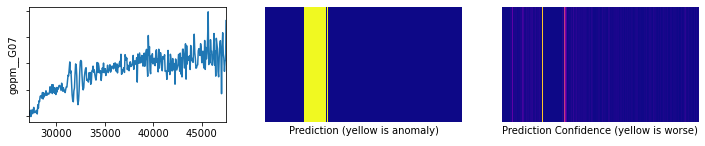

In [105]:
fig, axs = plt.subplots(3, sharex=False, sharey=False, figsize=(12, 2))

fig.tight_layout()

# fig.suptitle('Day of Earthquake Predictions by Second of Day (SoD) for ' + pass_id + "\n")

gs = plt.GridSpec(1, 3, height_ratios=[1]) 


axs[0] = plt.subplot(gs[0])
sns.lineplot(data=events[0].iloc[59:, :], x="sod", y=pass_id, ax=axs[0])
axs[0].set(yticklabels=[]) 
# axs[0].axvline(x=sod_annotations[sat_name], linestyle="dotted") # start 
# axs[0].axvline(x=sod_annotations[sat_name] + (30 * 60), linestyle="dotted") # approx end - 30 minutes later 
#TODo: do we need to revisit data generation / labeling? 
axs[0].margins(x=0)
axs[0].set_xlabel("")

axs[1] = plt.subplot(gs[1])
classification_bool = [0 if x == "normal" else 1 for x in classification]
sns.heatmap(np.array([classification_bool]), cbar=False, cmap="plasma", xticklabels=False, yticklabels=False, ax=axs[1])
axs[1].set_xlabel("Prediction (yellow is anomaly)") 

axs[2] = plt.subplot(gs[2])
sns.heatmap(np.array([classification_confidence]), cbar=False, cmap="plasma_r", xticklabels=False, yticklabels=False, ax=axs[2]) # .replace(0, np.nan)
axs[2].set_xlabel("Prediction Confidence (yellow is worse)") 


plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.5)


plt.show()

In [ ]:
events[0].iloc[59:, :].shape

In [ ]:
period_classification_df.shape

In [ ]:
# plt.figure(figsize=(12, 1))
# ax = sns.heatmap(np.array([classification_confidence]), cbar=False, cmap="plasma_r", xticklabels=False, yticklabels=False)
# ax.set_xlabel("Prediction Confidence (yellow is worse)") 
# plt.show()

In [ ]:
# plt.figure(figsize=(12, 1))
# classification_bool = [0 if x == "normal" else 1 for x in classification]
# ax = sns.heatmap(np.array([classification_bool]), cbar=False, cmap="plasma", xticklabels=False, yticklabels=False)
# ax.set_xlabel("Prediction (yellow is anomaly)") 
# plt.show()

In [ ]:
# plt.figure(figsize=(12, 3))
# ax = sns.lineplot(data=events[0], x="sod", y="alep__G07")
# ax.set(yticklabels=[]) 
# ax.axvline(x=sod_annotations["G07"], linestyle="dotted") # start 
# ax.axvline(x=sod_annotations["G07"] + (30 * 60), linestyle="dotted") # approx end - 30 minutes later 
# #TODO: do we need to revisit data generation / labeling? 
# ax.margins(x=0)
# ax.set_xlabel("Second of Day (with anomaly start and approximate end times)")
# plt.show()

